In [5]:
import torch

import numpy as np

from skimage.transform import resize

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt


import skimage as sk
import skimage.io as skio

from sklearn.model_selection import train_test_split

import glob

from tqdm import tqdm

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))


Using cuda device


In [43]:
import random
import math

In [7]:
def display_grid_of_images(array_of_images, array_of_names, w = 6, h = 5, normalize_rgb = False, hide_axes = True):
    num_rows = len(array_of_images)
    num_cols = len(array_of_images[0])
    
    assert len(array_of_names) == num_rows, "same num of rows for names and images"
    
    assert all([len(row) == num_cols for row in array_of_images]), "all rows need to be same length"
    assert all([len(row) == num_cols for row in array_of_names]), "all rows need to be same length for strings too"
    
    fig = plt.figure(figsize=(w * num_cols, h * num_rows))
    subplots = fig.subplots(num_rows, num_cols, squeeze = False)
    
    for row in range(num_rows):
        for col in range(num_cols):
            
            ax = subplots[row, col]
            ax.set_title(array_of_names[row][col])
            pixels = array_of_images[row][col]
            if hide_axes:
                ax.set_axis_off()
            
            if len(pixels.shape) == 2:
                # grayscale (scalars)
                ax.imshow(pixels,cmap='Greys_r')
            if len(pixels.shape) == 3:
                # rgb
                if normalize_rgb:
                    # gotta normalize the rgb ones too!
                    pixels = pixels - np.min(pixels)
                    pixels = pixels / np.max(pixels)
                ax.imshow(pixels)
def display_dictionary_of_images(dic, prefix = '', horiz = False, w = 6, h = 5, normalize_rgb = False, hide_axes = True):
    %matplotlib inline
    
    if horiz:
    
        fig = plt.figure(figsize=(w * len(dic), h))
        try:
            subplots = list(fig.subplots(1, len(dic)))
        except:
            subplots = [fig.subplots(1, len(dic))]
    else:
        fig = plt.figure(figsize=(w, h * len(dic)))
        try:
            subplots = list(fig.subplots(len(dic), 1))
        except:
            subplots = [fig.subplots(len(dic), 1)]
    
    keylist = list(dic.keys())
    
    for i in range(len(dic)):
        key = keylist[i]      
        pixels = dic[key]

        #Display the image
        ax = subplots[i]
        ax.set_title(prefix + ' ' + key)
        if hide_axes:
                ax.set_axis_off()
        if len(pixels.shape) == 2:
            # grayscale (scalars)
            ax.imshow(pixels,cmap='Greys_r')
        if len(pixels.shape) == 3:
            # rgb
            # gotta normalize the rgb ones too!
            if normalize_rgb:
                pixels = pixels - np.min(pixels)
                pixels = pixels / np.max(pixels)
            ax.imshow(pixels)

In [33]:
def show_cropped_image_with_points_data_thing(X, y):
    if not isinstance(X, np.ndarray):
        X = X.cpu().detach().numpy()
    
    if not isinstance(y, np.ndarray):
        y = y.cpu().detach().numpy()
    
    X = X.transpose((1, 2, 0))
    
    y = y.reshape((58, 2))
    
    fig = plt.figure(figsize=(8, 10))
    
    ax = fig.subplots()
    ax.imshow(X)

    ax.scatter(*zip(*(y * np.array([240,180]))))


In [8]:
def get_data():
    anno_names = glob.glob("data/imm_face_db/*.asf")
    face_names = [s[:-3]+'jpg' for s in anno_names]
    
    keypoints = []

    for anno_name in anno_names:
        file = open(anno_name)
        points = file.readlines()[16:74]
        landmark = []

        for point in points:
            x,y = point.split('\t')[2:4]
            landmark.append([float(x), float(y)])
        landmark = np.array(landmark).flatten()
        # the keypoints
        keypoints.append(landmark.astype('float32'))     
        
    
    keypoints = np.array(keypoints)
    
    faces = []

    for face_name in face_names:

        img = skio.imread(face_name)
        img = (img.astype(np.float32) / 255 - 0.5)
        img = resize(img, (180,240), anti_aliasing=True)
        img = np.mean(img, axis = 2)
        faces.append(img)
        
    faces = np.array(faces)
    
    return faces, keypoints


In [9]:
X_all, y_all = get_data()

In [10]:
y_all.shape

(240, 116)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=48, random_state=None, shuffle = False)

In [12]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((192, 180, 240), (48, 180, 240), (192, 116), (48, 116))

In [69]:
class KeypointsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self,X, y, transform=None, do_aug = False):
        
        assert len(X) == len(y)
        
                    
        self.faces = torch.Tensor(X).unsqueeze(1)
        
        self.do_aug = do_aug
        
        
        if do_aug:
            self.jitter = transforms.ColorJitter(brightness = .5, contrast=.5, saturation=.5,hue=.2)
        
        

        
        self.keypoints = torch.Tensor(y)
        
    def __len__(self):
        return len(self.keypoints)
    
    def image_aug_transforms(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        
        if random.random() > 0.5:
            image = self.jitter(image)
            
        if random.random() > 0.5:
            # do rotation
            angle = random.randint(-30, 30)
            
            image = transforms.functional.rotate(image, angle)
            theta = torch.tensor(-angle * math.pi / 180)
            c, s = torch.cos(theta), torch.sin(theta)
            rot = torch.stack([torch.stack([c, s]),
                   torch.stack([-s, c])])
            
            keypoints2d = torch.reshape(keypoints, (58, 2))
            keypoints2d = keypoints2d - 0.5
            
            keypoints2d_rot = keypoints2d @ rot
            
            keypoints2d_rot = keypoints2d_rot + 0.5
            keypoints = torch.flatten(keypoints2d_rot)
            
            
        return {'image': image, 'keypoints': keypoints}

    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()

        
        sample = {'image': self.faces[idx], 'keypoints': self.keypoints[idx]}

        if self.do_aug:
            sample = self.image_aug_transforms(sample)
        
        return sample


In [70]:
train_dataset = KeypointsDataset(X_train, y_train, do_aug = True)

In [71]:
val_dataset = KeypointsDataset(X_val, y_val)

In [72]:
train_dataset[0]['image'].shape

torch.Size([1, 180, 240])

In [73]:
def train(dataloader, model, loss_fn, optimizer):
    
    size = len(dataloader.dataset)
    print(f"training on {size} samples")
    model.train()
    
    total_loss = 0
    
    for bidx, batch in tqdm(enumerate(dataloader)):
        
        # send data to gpu
        x, y = batch['image'], batch['keypoints']
        x, y = x.to(device), y.to(device)
        
        # do the forward/backward pass
        model.zero_grad()
        output = model(x)
        loss = loss_fn(output,y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss
        
    mean_loss = total_loss/(bidx + 1)
        
    return mean_loss

def validate(dataloader, model, loss_fn):
    
    size = len(dataloader.dataset)
    print(f"validating on {size} samples")
    model.eval()
    
    total_loss = 0
    
    for bidx, batch in enumerate(dataloader):
        
        # send data to gpu
        x, y = batch['image'], batch['keypoints']
        x, y = x.to(device), y.to(device)
        
        # do the forward pass
        output = model(x)
        loss = loss_fn(output,y)      
        total_loss += loss
        
    mean_loss = total_loss/(bidx + 1)
        
    return mean_loss

def predict(dataloader, model):
    
    outputs = []
    model.eval()
    for bidx, batch in enumerate(dataloader):
        
        # send data to gpu
        x, y = batch['image'], batch['keypoints']
        x, y = x.to(device), y.to(device)
        
        # do the forward pass
        output = model(x)
        
        # send data back to cpu and convert to np
        output = output.cpu()
        outputs.append(output.detach().numpy())
    
    all_outputs = np.stack(outputs, axis=0)
    return all_outputs
        
        

In [74]:
BATCH_SIZE = 1
NUM_EPOCHS = 25

In [75]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

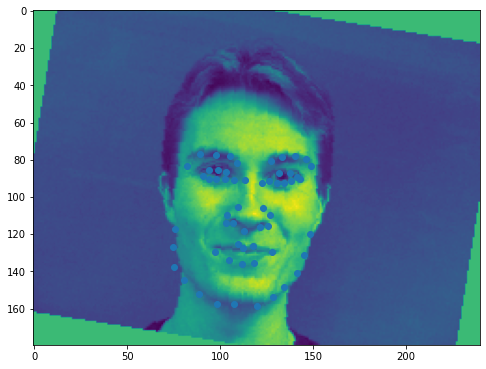

In [76]:
show_cropped_image_with_points_data_thing(*train_dataset[58].values())

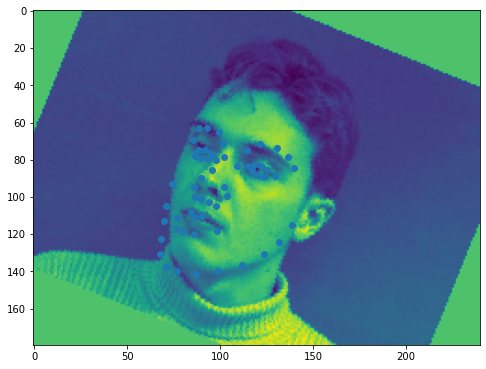

In [77]:
show_cropped_image_with_points_data_thing(*train_dataset[69].values())

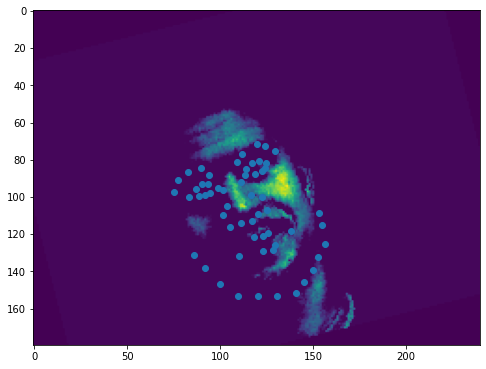

In [78]:
show_cropped_image_with_points_data_thing(*train_dataset[42].values())

In [79]:
class NoseNet(nn.Module):

    def __init__(self):
        super(NoseNet, self).__init__()
        # 1 input image channel, 12 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 12, 8)
        self.conv2 = nn.Conv2d(12, 12, 8)
        self.conv3 = nn.Conv2d(12, 12, 8)
        self.conv4 = nn.Conv2d(12, 12, 8)
        self.conv5 = nn.Conv2d(12, 12, 8)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(3276, 500)  # 5*5 from image dimension
        self.fc2 = nn.Linear(500, 116)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [97]:
model = NoseNet().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
print(model)

NoseNet(
  (conv1): Conv2d(1, 12, kernel_size=(8, 8), stride=(1, 1))
  (conv2): Conv2d(12, 12, kernel_size=(8, 8), stride=(1, 1))
  (conv3): Conv2d(12, 12, kernel_size=(8, 8), stride=(1, 1))
  (conv4): Conv2d(12, 12, kernel_size=(8, 8), stride=(1, 1))
  (conv5): Conv2d(12, 12, kernel_size=(8, 8), stride=(1, 1))
  (fc1): Linear(in_features=3276, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=116, bias=True)
)


In [98]:
train_loss_history = []
val_loss_history = []

In [99]:
for epoch in range(NUM_EPOCHS):
    train_loss = train(train_loader, model, loss_fn, optimizer)
    
    val_loss = validate(val_loader, model, loss_fn)
    
    train_loss_history.append(train_loss.item())
    val_loss_history.append(val_loss.item())

    print(f"epoch {epoch}, train_loss {train_loss}, val_loss {val_loss}")

training on 192 samples


192it [00:01, 169.89it/s]


validating on 48 samples
epoch 0, train_loss 0.02515414170920849, val_loss 0.008902188390493393
training on 192 samples


192it [00:00, 196.82it/s]


validating on 48 samples
epoch 1, train_loss 0.005513460375368595, val_loss 0.008686663582921028
training on 192 samples


192it [00:01, 189.69it/s]


validating on 48 samples
epoch 2, train_loss 0.005271321162581444, val_loss 0.007005240302532911
training on 192 samples


192it [00:01, 186.12it/s]


validating on 48 samples
epoch 3, train_loss 0.005064679309725761, val_loss 0.005127941258251667
training on 192 samples


192it [00:01, 191.05it/s]


validating on 48 samples
epoch 4, train_loss 0.0044772811233997345, val_loss 0.003970364108681679
training on 192 samples


192it [00:00, 201.55it/s]


validating on 48 samples
epoch 5, train_loss 0.004406287334859371, val_loss 0.0038079998921602964
training on 192 samples


192it [00:00, 208.69it/s]


validating on 48 samples
epoch 6, train_loss 0.004471356049180031, val_loss 0.003350028535351157
training on 192 samples


192it [00:00, 219.26it/s]


validating on 48 samples
epoch 7, train_loss 0.0041686468757689, val_loss 0.0034574116580188274
training on 192 samples


192it [00:00, 207.12it/s]


validating on 48 samples
epoch 8, train_loss 0.00401740986853838, val_loss 0.0035834284499287605
training on 192 samples


192it [00:01, 185.69it/s]


validating on 48 samples
epoch 9, train_loss 0.0041882749646902084, val_loss 0.0034319860860705376
training on 192 samples


192it [00:00, 197.53it/s]


validating on 48 samples
epoch 10, train_loss 0.0040911100804805756, val_loss 0.003366888966411352
training on 192 samples


192it [00:00, 211.15it/s]


validating on 48 samples
epoch 11, train_loss 0.004105639178305864, val_loss 0.003822015132755041
training on 192 samples


192it [00:00, 211.27it/s]


validating on 48 samples
epoch 12, train_loss 0.004188114311546087, val_loss 0.00330571411177516
training on 192 samples


192it [00:00, 210.54it/s]


validating on 48 samples
epoch 13, train_loss 0.004047630820423365, val_loss 0.0033474089577794075
training on 192 samples


192it [00:00, 201.38it/s]


validating on 48 samples
epoch 14, train_loss 0.004100580234080553, val_loss 0.0033404554706066847
training on 192 samples


192it [00:00, 207.13it/s]


validating on 48 samples
epoch 15, train_loss 0.00406130263581872, val_loss 0.0036902399733662605
training on 192 samples


192it [00:00, 202.49it/s]


validating on 48 samples
epoch 16, train_loss 0.0040962109342217445, val_loss 0.003310250584036112
training on 192 samples


192it [00:01, 172.70it/s]


validating on 48 samples
epoch 17, train_loss 0.004096303600817919, val_loss 0.003317908849567175
training on 192 samples


192it [00:00, 203.52it/s]


validating on 48 samples
epoch 18, train_loss 0.003969903104007244, val_loss 0.003343547461554408
training on 192 samples


192it [00:00, 202.21it/s]


validating on 48 samples
epoch 19, train_loss 0.004027222283184528, val_loss 0.003261320060119033
training on 192 samples


192it [00:00, 195.13it/s]


validating on 48 samples
epoch 20, train_loss 0.003872395260259509, val_loss 0.003250422654673457
training on 192 samples


192it [00:01, 147.74it/s]


validating on 48 samples
epoch 21, train_loss 0.004150253254920244, val_loss 0.003234142903238535
training on 192 samples


192it [00:00, 196.50it/s]


validating on 48 samples
epoch 22, train_loss 0.004003005102276802, val_loss 0.0031969507690519094
training on 192 samples


192it [00:00, 198.76it/s]


validating on 48 samples
epoch 23, train_loss 0.004297574982047081, val_loss 0.0032449038699269295
training on 192 samples


192it [00:00, 213.86it/s]


validating on 48 samples
epoch 24, train_loss 0.004098597913980484, val_loss 0.003175061196088791


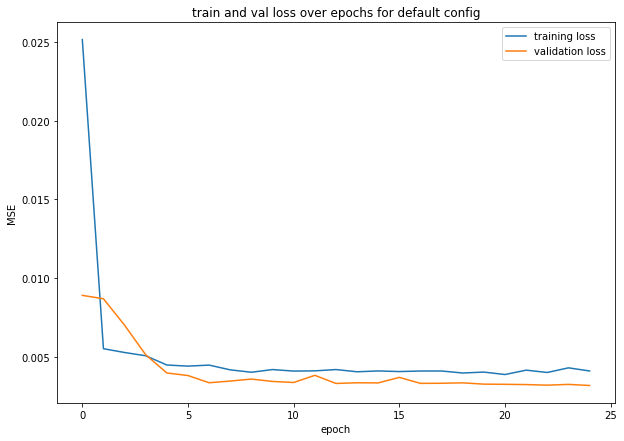

In [100]:
plt.figure(figsize = (10, 7))
plt.plot(range(len(train_loss_history)), train_loss_history, label = 'training loss')
plt.plot(range(len(val_loss_history)), val_loss_history, label = 'validation loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.title('train and val loss over epochs for default config')
plt.legend()


In [101]:
out = predict(val_loader,model)

In [102]:
out = out.reshape((out.shape[0], out.shape[-1]))

In [103]:
y_val.shape

(48, 116)

In [104]:
out.shape

(48, 116)

In [105]:
rankings = list(range(len(out)))

In [106]:
def error_of_index(i):
    predicted = out[i]
    ground_truth = y_val[i]
    return sum((predicted - ground_truth)**2)

In [107]:
rankings.sort(key=error_of_index)

### The best predictions

In [108]:
rankings[:5]

[23, 10, 22, 39, 2]

In [109]:
def show_image_and_points(ax, image_idx):
    ax.set_title(f"validation set number {image_idx}")
    ax.imshow(X_val[image_idx], cmap='Greys_r')
    pred_point = out[image_idx] 
    pred_point = pred_point.reshape((58,2))* np.array([240, 180])
    
    gt_point = y_val[image_idx]
    gt_point = gt_point.reshape((58,2))* np.array([240, 180])
    
    ax.scatter(gt_point[:,0], gt_point[:,1], color='blue', label='ground truth')
    ax.scatter(pred_point[:,0], pred_point[:,1], marker='x', color='orange',label = 'prediction')
    ax.legend()

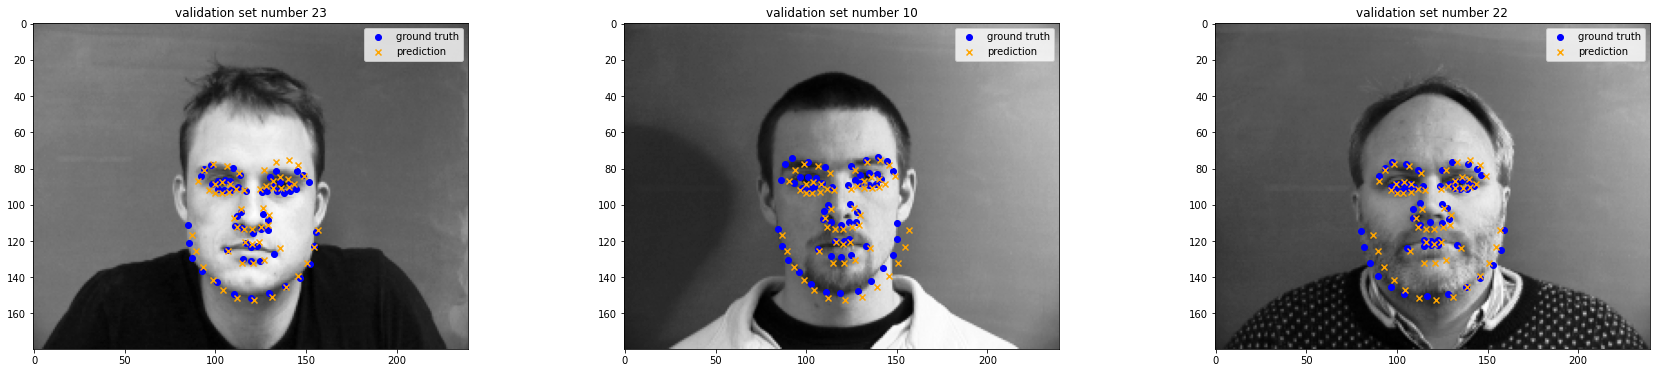

In [110]:
fig = plt.figure(figsize=(30, 6))
axes = fig.subplots(1, 3)
for ax, idx in list(zip(axes, rankings[:3])):
    show_image_and_points(ax, idx)

### The worst predictions

In [111]:
rankings[-5:]

[8, 36, 19, 41, 13]

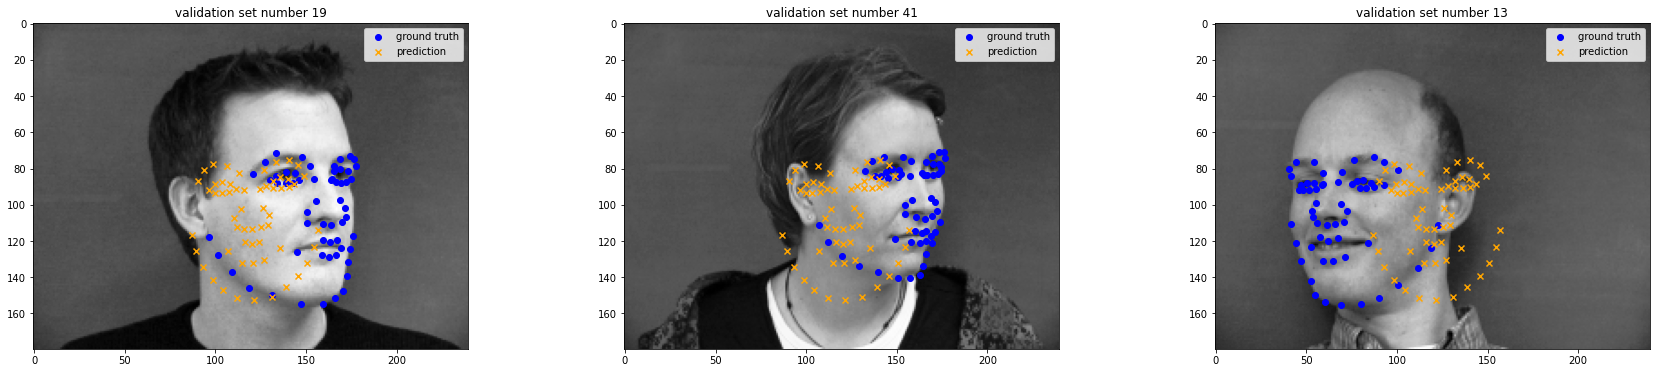

In [112]:
fig = plt.figure(figsize=(30, 6))
axes = fig.subplots(1, 3)
for ax, idx in list(zip(axes, rankings[-3:])):
    show_image_and_points(ax, idx)

### Visualizing filters

In [113]:
print(model)

NoseNet(
  (conv1): Conv2d(1, 12, kernel_size=(8, 8), stride=(1, 1))
  (conv2): Conv2d(12, 12, kernel_size=(8, 8), stride=(1, 1))
  (conv3): Conv2d(12, 12, kernel_size=(8, 8), stride=(1, 1))
  (conv4): Conv2d(12, 12, kernel_size=(8, 8), stride=(1, 1))
  (conv5): Conv2d(12, 12, kernel_size=(8, 8), stride=(1, 1))
  (fc1): Linear(in_features=3276, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=116, bias=True)
)


In [114]:
model.conv1.weight.cpu().detach().numpy().shape

(12, 1, 8, 8)

In [115]:
retrieve = lambda x: x.weight.cpu().detach().numpy()

In [118]:
conv1_w, conv2_w, conv3_w, conv4_w, conv5_w = retrieve(model.conv1), retrieve(model.conv2), retrieve(model.conv3), retrieve(model.conv4), retrieve(model.conv5)

In [119]:
def show_filters(weights):
    rows, cols = weights.shape[0], weights.shape[1]
    titles = [[f"in: {in_c}, out: {out_c}" for in_c in range(cols)] for out_c in range(rows)]
    
    display_grid_of_images(weights, titles, w = 1.5, h = 1.5, normalize_rgb = False)

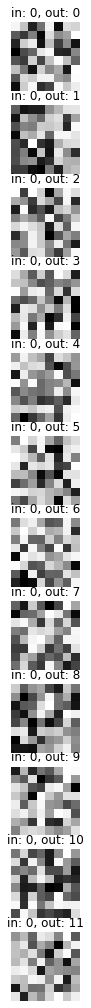

In [120]:
show_filters(conv1_w)

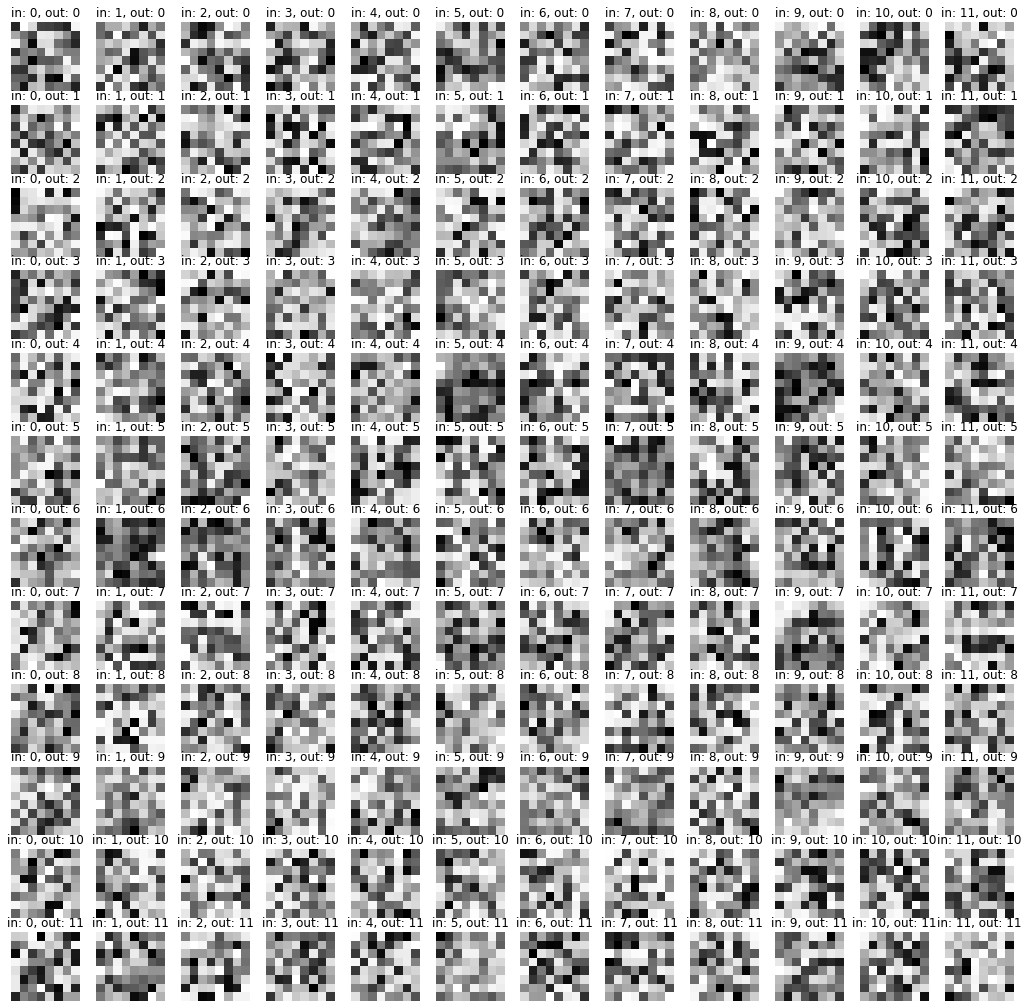

In [121]:
show_filters(conv2_w)

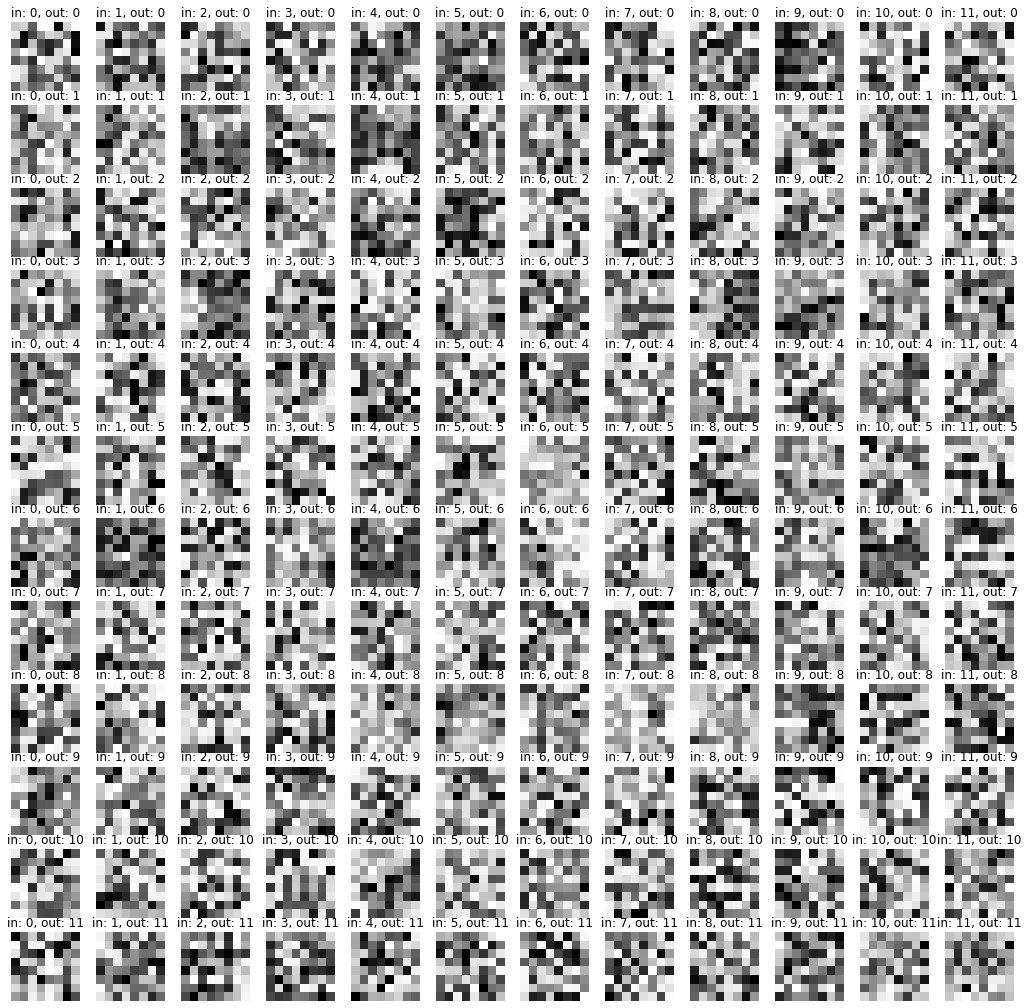

In [122]:
show_filters(conv3_w)

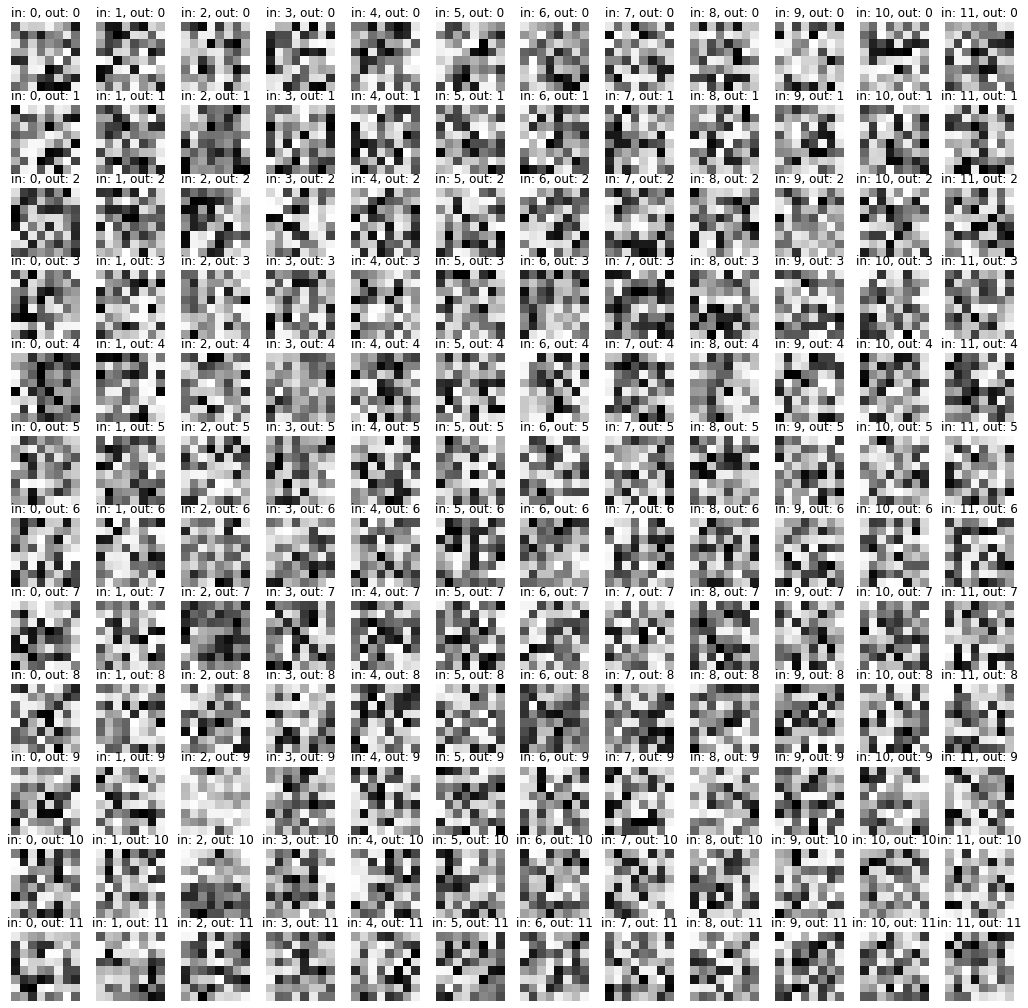

In [123]:
show_filters(conv4_w)

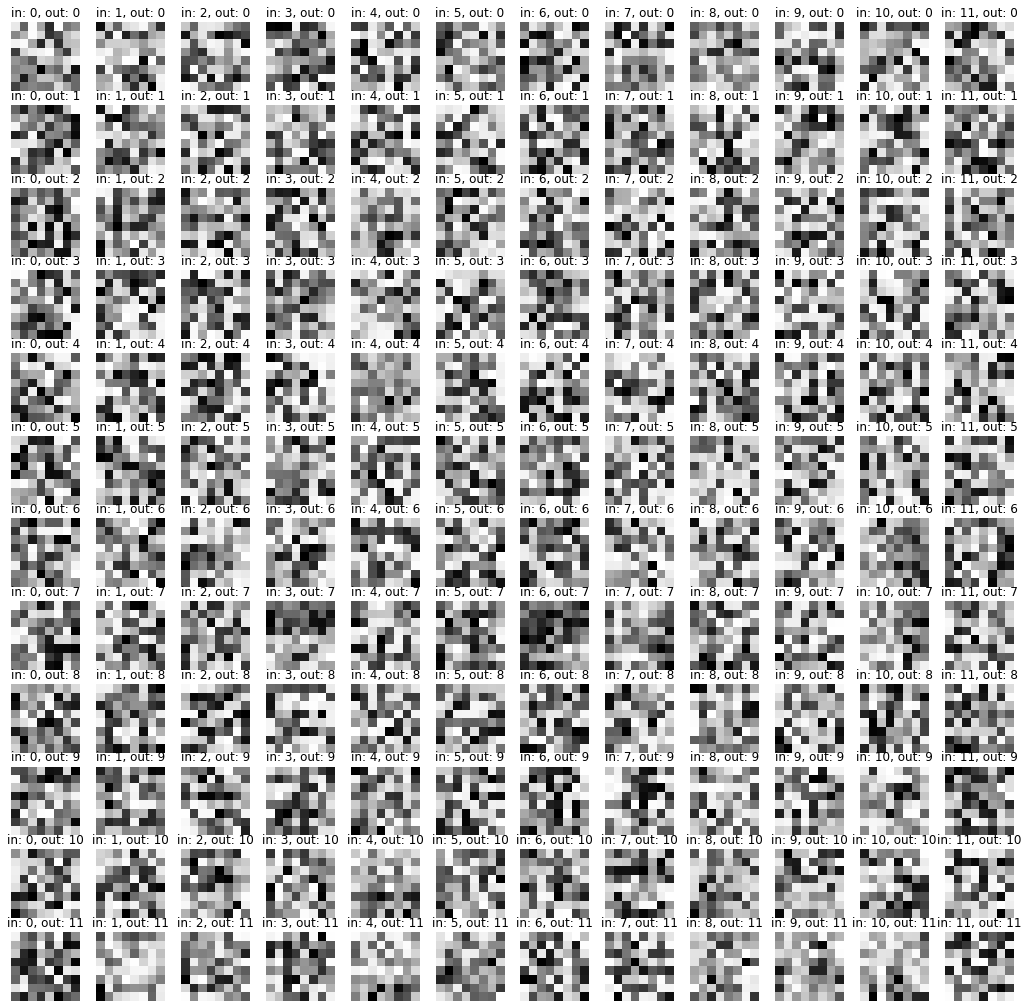

In [124]:
show_filters(conv5_w)